In [1]:
import numpy as np
import matplotlib.pyplot as plt

from uot import UOT, EntRegUOT
from uot import exact_uot, exact_entreg_uot
from uot import calc_B, calc_f, calc_g
from sinkhorn import calc_R, calc_U, sinkhorn_entreg_uot, sinkhorn
from utils import norm_inf

## Experiments

### Varying epsilon (Synthetic Data)

#### Preparation

In [2]:
# Dimension
n = 10

# Regularization
tau = np.float128(5.0)

# Mass normalization
alpha = 2.0
beta = 4.0

# Number of eps
neps = 20

In [3]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=1.0, high=50.0, size=(n, n)).astype(np.float128)
C = (C + C.T) / 2.0

# Marginal vectors
a = np.random.uniform(0.1, 1.0, size=n).astype(np.float128)
b = np.random.uniform(0.1, 1.0, size=n).astype(np.float128)

a = a / a.sum() * alpha
b = b / b.sum() * beta

#### Execution

In [4]:
# Original UOT problem
uot = UOT(C, a, b, tau)

# Optimal solution
f_optimal, X_optimal = exact_uot(uot)

print('Optimal:', f_optimal)

Optimal: 20.904673686334995


In [5]:
# Epsilons
eps_arr = np.linspace(start=1.0, stop=0.05, num=neps).astype(np.float128)

kfs, kcs = np.zeros((2, neps))

for i, eps in enumerate(eps_arr):
    # Entropic regularization parameter
    U = calc_U(uot, eps)
    eta = eps / U

    # Convert to Entropic Regularized UOT
    euot = EntRegUOT(C, a, b, tau, eta)

    # Sinkhorn
    _, log = sinkhorn_entreg_uot(euot, eps)

    # Find kf
    kf = log['k_stop']

    # Find kc
    f_approx = np.array([
        calc_f(uot, calc_B(euot, u, v))
        for u, v in zip(log['u'], log['v'])
    ])
    kc = np.where(f_approx - f_optimal > eps)[0][-1]

    kfs[i] = kf
    kcs[i] = kc + 1

(1.05, -0.05)

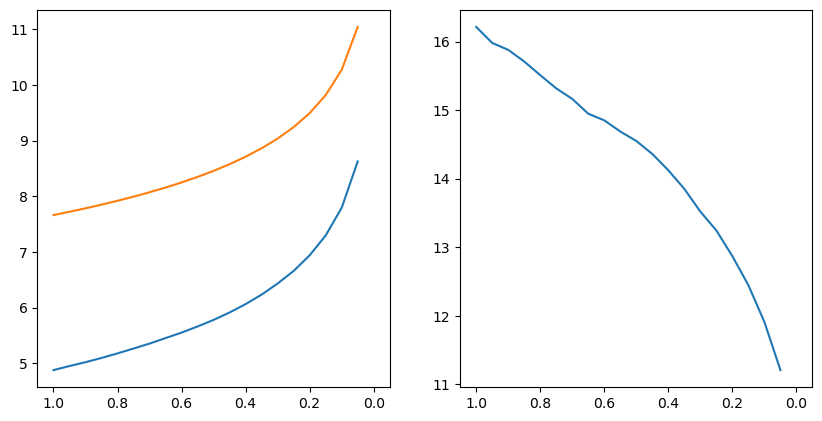

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax[0].plot(eps_arr, np.log(kcs), label='\log k_f')
ax[0].plot(eps_arr, np.log(kfs), label='\log k_c')
ax[0].set_xlim(1.0 + 0.05, 0 - 0.05)

ax[1].plot(eps_arr, kfs / kcs, label='\log k_f')
ax[1].set_xlim(1.0 + 0.05, 0 - 0.05)

### Theory check (Synthetic data)

#### Preparation

In [125]:
# Dimension
n = 100

# Regularization
tau = np.float128(1.0)
eta = np.float128(0.05)

# Number of Sinkhorn iterations
niters = 1000

In [126]:
# np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=1.0, high=100.0, size=(n, n)).astype(np.float128)
C = (C + C.T) / 2.0

# Marginal vectors
a = np.random.uniform(0.1, 10.0, size=n).astype(np.float128)
b = np.random.uniform(0.1, 10.0, size=n).astype(np.float128)

Unbalanced OT

In [127]:
uot = UOT(C, a, b, tau)

Solve UOT with CVXPY

In [128]:
_, X_hat = exact_uot(uot)

Entropic UOT problem

In [129]:
euot = EntRegUOT(C, a, b, tau, eta)

Solve Entropic UOT with CVXPY

In [130]:
_, u_star, v_star = exact_entreg_uot(euot)

In [132]:
X_star = calc_B(euot, u_star, v_star)
a_star = X_star.sum(-1)
b_star = X_star.sum(0)

Solve Entropic UOT with Sinkhorn iterations

In [133]:
_, log = sinkhorn(euot, niters)

#### Convergence

In [134]:
f_optimal = calc_f(uot, X_hat)
g_optimal = calc_g(euot, X_star)

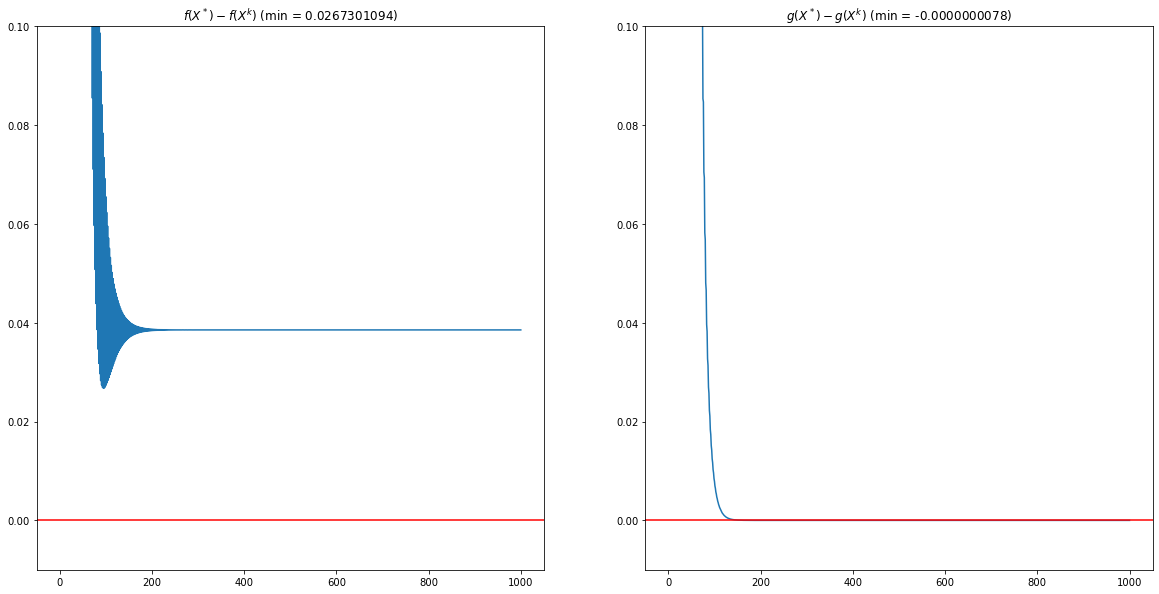

In [135]:
fs, gs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    Xk = calc_B(euot, uk, vk)
    fs[k] = calc_f(uot, Xk)
    gs[k] = calc_g(euot, Xk)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(range(niters + 1), fs - f_optimal)
ax[0].axhline(0, color='red')
ax[0].set_ylim(-0.01, 0.1)
ax[0].set_title(f'$f(X^*) - f(X^k)$ (min = {np.min(fs - f_optimal):.10f})')

ax[1].plot(range(niters + 1), gs - g_optimal)
ax[1].axhline(0, color='red')
ax[1].set_ylim(-0.01, 0.1)
ax[1].set_title(f'$g(X^*) - g(X^k)$ (min = {np.min(gs - g_optimal):.10f})')

plt.show()

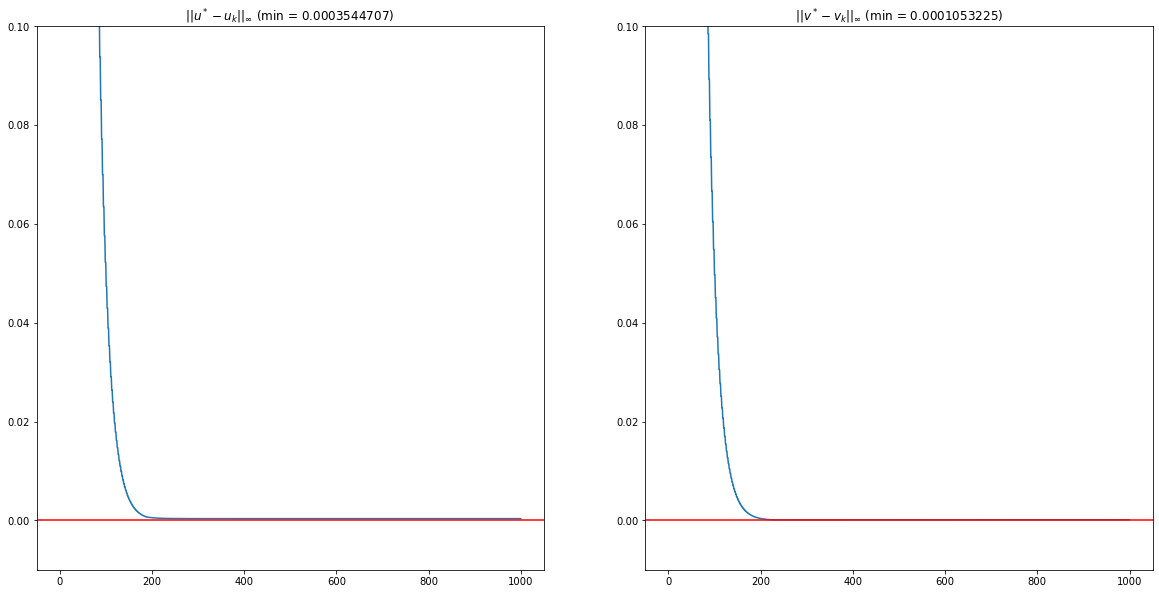

In [136]:
dus, dvs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    dus[k] = norm_inf(uk - u_star)
    dvs[k] = norm_inf(vk - v_star)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(range(niters + 1), dus)
ax[0].axhline(0, color='red')
ax[0].set_ylim(-0.01, 0.1)
ax[0].set_title(f'$||u^* - u_{{k}}||_\infty$ (min = {np.min(dus):.10f})')

ax[1].plot(range(niters + 1), dvs)
ax[1].axhline(0, color='red')
ax[1].set_ylim(-0.01, 0.1)
ax[1].set_title(f'$||v^* - v_{{k}}||_\infty$ (min = {np.min(dvs):.10f})')

plt.show()

#### Lemma 1

$$
\frac{u^*}{\tau} = \log(a) - \log(a^*) \\
\frac{v^*}{\tau} = \log(b) - \log(b^*)
$$

0.00744728517724618181


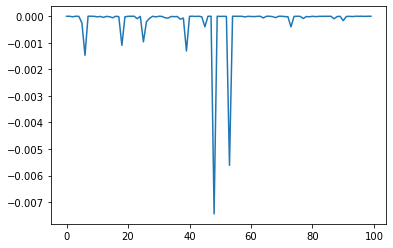

In [137]:
print(norm_inf(u_star / tau - np.log(a / a_star)))

plt.plot(u_star / tau - np.log(a / a_star))
plt.show()

0.0026288116405667350667


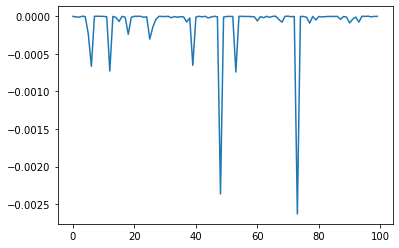

In [138]:
print(norm_inf(v_star / tau - np.log(b / b_star)))

plt.plot(v_star / tau - np.log(b / b_star))
plt.show()

#### Lemma 2

$$
\Big| \log\left( \frac{a_i^*}{a_i^k} \right) -  \frac{u_i^* - u_i^k}{\eta}\Big| \leq  \max_{1 \leq j \leq n} \frac{|v^*_j - v^{k}_j|}{\eta}
$$

$$
\Big| \log\left( \frac{b_j^*}{b_j^k} \right) -  \frac{v_j^* - v_j^k}{\eta}\Big| \leq  \max_{1 \leq i \leq n} \frac{|u^*_i - u^{k}_i|}{\eta}
$$

2.7755575615628914e-17


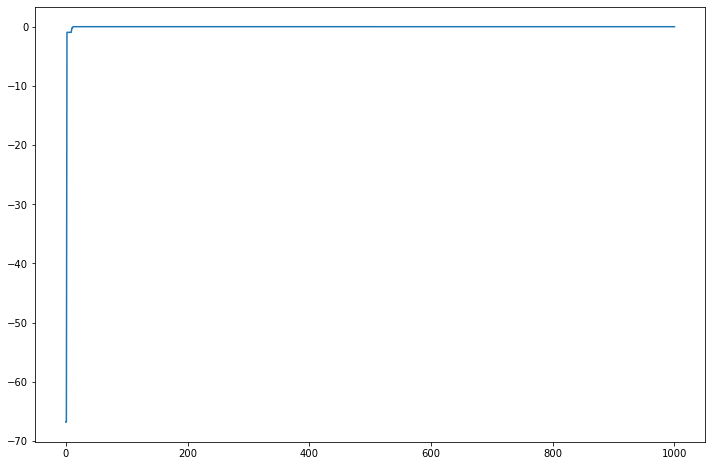

In [139]:
lhs, rhs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    X = calc_B(euot, uk, vk)
    ak = X.sum(-1)

    l = norm_inf(np.log(a_star / ak) - (u_star - uk) / eta)
    r = norm_inf((v_star - vk) / eta)

    lhs[k], rhs[k] = l, r

print(np.max(lhs - rhs))

plt.figure(figsize=(12, 8))
plt.plot(lhs - rhs)
plt.show()

5.551115123125783e-17


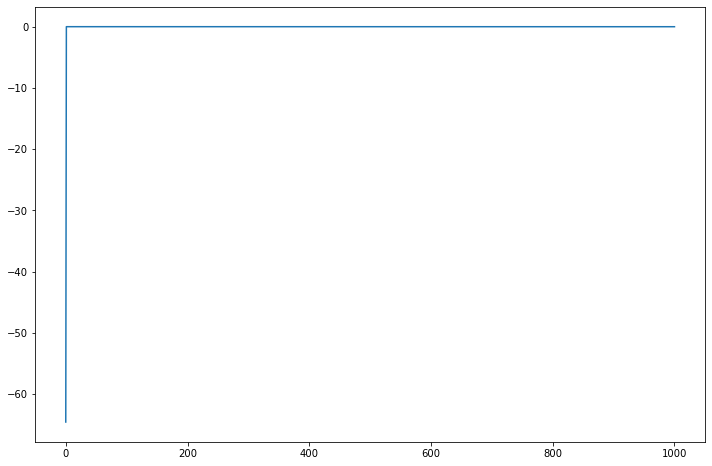

In [140]:
lhs, rhs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    X = calc_B(euot, uk, vk)
    bk = X.sum(0)

    l = norm_inf(np.log(b_star / bk) - (v_star - vk) / eta)
    r = norm_inf((u_star - uk) / eta)

    lhs[k], rhs[k] = l, r

print(np.max(lhs - rhs))

plt.figure(figsize=(12, 8))
plt.plot(lhs - rhs)
plt.show()

#### Lemma 3

$$
\max \{ \|u^*\|_{\infty},\|v^*\|_\infty \} \le \tau R
$$

In [141]:
R = calc_R(euot)

In [142]:
lhs = max(norm_inf(u_star), norm_inf(v_star))
rhs = tau * R
print(lhs - rhs)

-1980.7857530240473671


#### Lemma 4

$$
g(X^*) + (2 \tau + \eta) x^* = \tau (\alpha + \beta) \\
f(\hat{X}) + 2 \tau \hat{x} = \tau (\alpha + \beta)
$$

In [143]:
alpha, beta = a.sum(), b.sum()

In [144]:
lhs1 = calc_g(euot, X_star) + (2 * tau + eta) * np.sum(X_star)
lhs2 = calc_f(uot, X_hat) + 2 * tau * np.sum(X_hat)
rhs = tau * (alpha + beta)
print(lhs1 - rhs)
print(lhs2 - rhs)

-0.00012250554507686750583
0.000103026171351383588615


#### Theorem 1

$$
\max \{ \| u^{k} -  u^*\|_\infty, \| v^{k} -  v^*\|_\infty \} \le \Big( \frac{\tau}{\tau + \eta} \Big)^k \times \tau \times R
$$

In [145]:
R = calc_R(euot)

0.6813186813186813


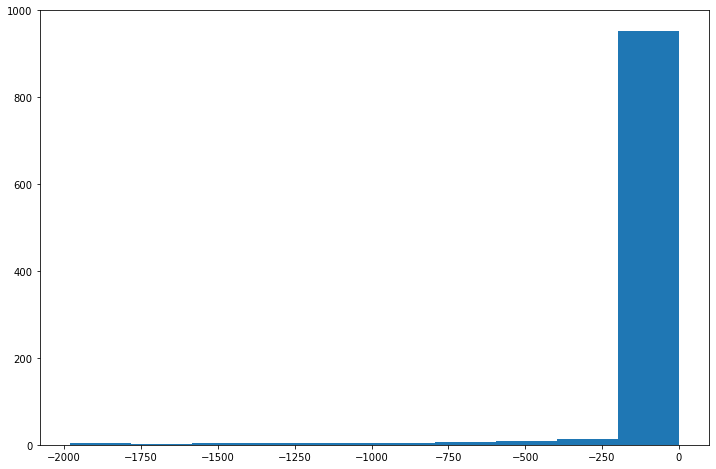

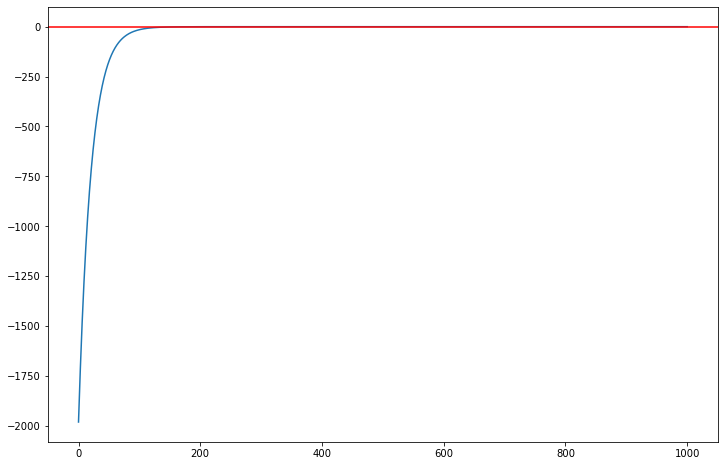

In [146]:
lhs = np.maximum(np.max(np.abs(log['u'] - u_star), -1), np.max(np.abs(log['v'] - v_star), -1))
rhs = (tau / (tau + eta)) ** np.arange(niters + 1) * tau * R

print((lhs > rhs).mean())

plt.figure(figsize=(12, 8))
plt.hist(lhs - rhs)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(lhs - rhs)
plt.axhline(0, c='r')
plt.show()

#### Corollary 2

$$
    \sum_{i, j = 1}^n X^*_{ij} \leq \left(\dfrac{1}{2} + \dfrac{\eta \log n}{2 \tau - 2\eta \log n}\right)(\alpha + \beta) + \dfrac{1}{6 \log n}
$$

In [147]:
lhs = X_star.sum()
rhs = (0.5 + (eta * np.log(n)) / (2 * tau - 2 * eta * np.log(n))) * (alpha + beta) + 1 / (6 * np.log(n))

print(lhs, rhs, lhs - rhs)

27.53281994272968916 626.63580854361815825 -599.1029886008884691


$$
    \sum_{i, j = 1}^n \hat{X}_{ij} \leq \dfrac{\alpha + \beta}{2}
$$

In [148]:
lhs = X_hat.sum()
rhs = (alpha + beta) / 2

print(lhs, rhs, lhs - rhs)

27.145092327002633 482.31972352124559658 -455.1746311942429636


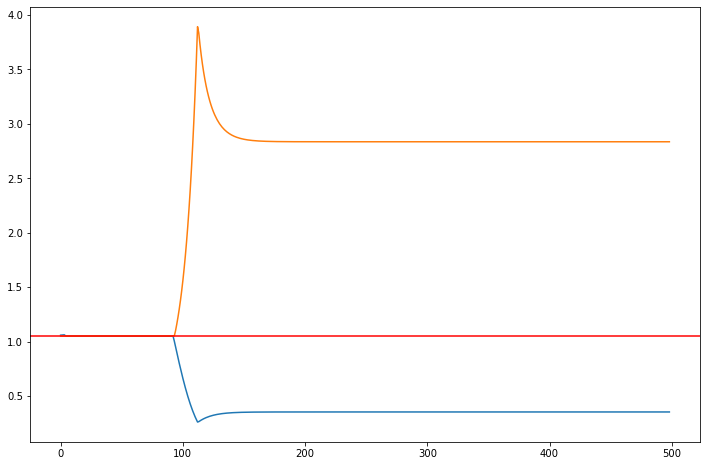

In [149]:
y1, y2 = [], []

for k in range(2, niters, 2):
    y1.append(norm_inf(log['v'][k] - v_star) / norm_inf(log['u'][k+1] - u_star))
    y2.append(norm_inf(log['u'][k-1] - u_star) / norm_inf(log['v'][k] - v_star))

plt.figure(figsize=(12, 8))
plt.plot(y1)
plt.plot(y2)
plt.axhline((tau + eta) / tau, color='red')
plt.show()

### Varying epsilon (Real Data)